We shall use the fast Fourier transform (FFT) to numerically find the Fourier transform of the Bessel function of 1st kind $J_n(x)$

\begin{equation}
    \hat{J}_n(x) = \int_{-\infty}^{\infty} J_n(x)\exp(-2\pi i kx)\,dx.
\end{equation}

The theoretical formula for this is

\begin{equation}
    \hat{\mathcal{J}}_n(k) = 2(-i)^n(1-4\pi^2k^2)^{-1/2}T_n(2\pi k),
\end{equation}

where $T_n(\mu)$ is the Chebyshev polynomial of order $n$, defined by

\begin{equation}
    T_n(\mu) =
    \begin{cases}
        \cos(n\theta) & \mu = \cos\theta, \\
        0 & |\mu| > 1.
    \end{cases}
\end{equation}

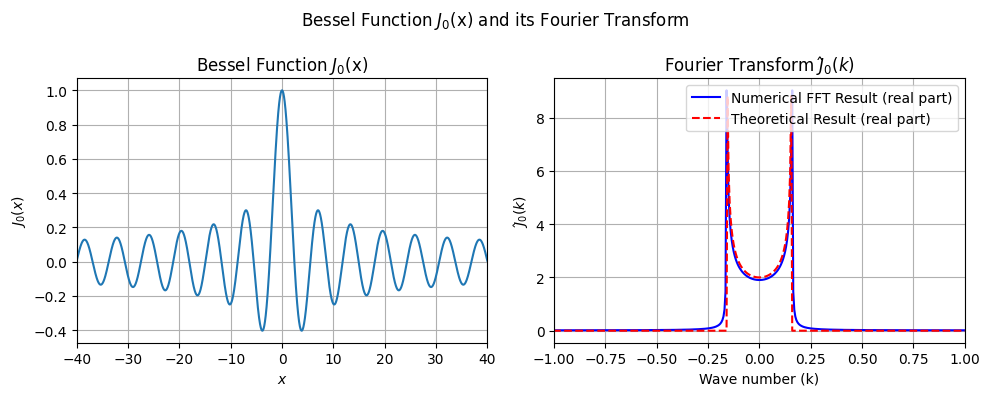

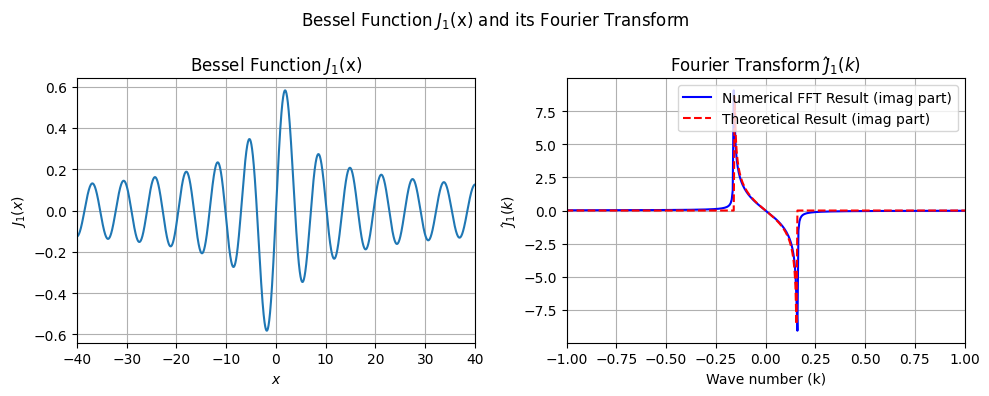

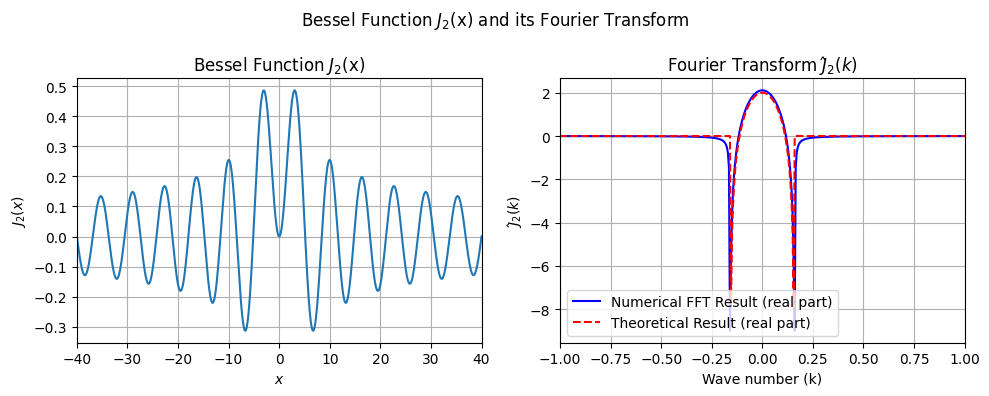

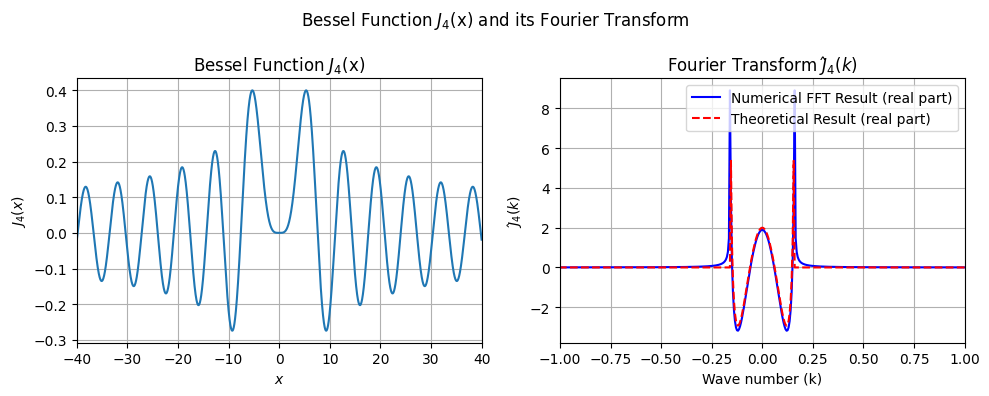

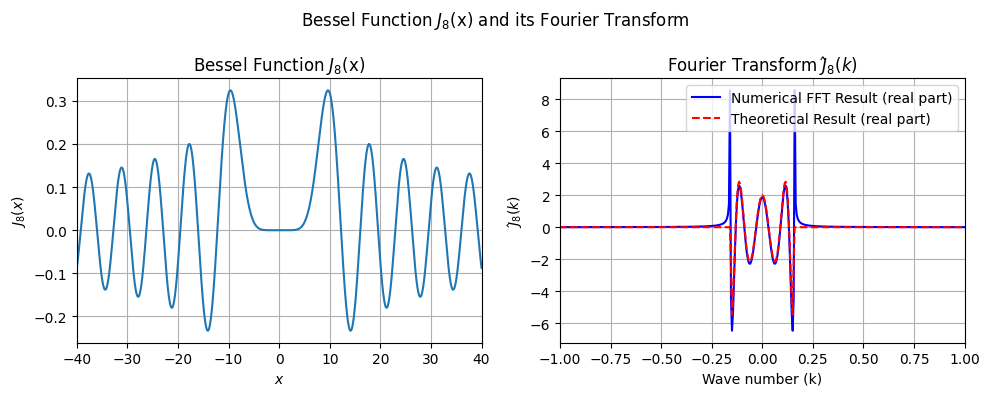

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy.fft import fft, fftfreq, fftshift
import time

def theoretical_transform(n, k):
    '''
    Calculates the theoretical Fourier Transform.
    '''
    # Valid region.
    mu = 2 * np.pi * k
    valid_k_mask = np.abs(mu) < 1.0

    # Initialize the result array with complex zeros.
    jn_hat_theory = np.zeros_like(k, dtype=complex)

    # Calculate all the relevant terms.
    chebyshev_tn = np.cos(n * np.arccos(mu[valid_k_mask]))
    denominator = np.sqrt(1 - mu[valid_k_mask]**2)
    prefactor = 2 * ((-1j)**n)

    jn_hat_theory[valid_k_mask] = prefactor * chebyshev_tn / denominator

    return jn_hat_theory

def compute_fft_of_jn(n, X, N):
    '''
    Computes the Fourier Transform over a symmetric interval [-X, X] using FFT.
    '''
    # Define the grid for the one-sided integral over [0, X)
    dx = X / N
    x = np.linspace(0, X, N, endpoint=False) # x goes from 0 to X - dx
    # Sample the Bessel function Jₙ(x)
    jn_x = jv(n, x)

    # Compute the FFT. Scaling by dx approximates the integral I_1
    fft_I1 = dx * fft(jn_x)
    # Get the corresponding frequencies (wave numbers k)
    k = fftfreq(N, d=dx)

    # 4. Use the parity rules to construct the full transform I_2
    fft_I2 = np.zeros_like(fft_I1)
    if n % 2 == 0:  # J_n is an even function
        fft_I2.real = 2 * fft_I1.real
    else:  # J_n is an odd function
        fft_I2.imag = 2 * fft_I1.imag

    return k, fft_I2

def plot_and_compare(n, X, N):
    '''
    Generates the plots for a given order n.
    '''
    x_plot = np.linspace(-X, X, 2*N)
    jn_plot = jv(n, x_plot)

    k, jn_hat_fft = compute_fft_of_jn(n, X, N)
    jn_hat_theory = theoretical_transform(n, k)

    # Use fftshift to reorder k and the FFT result for plotting
    k_shifted = fftshift(k)
    jn_hat_fft_shifted = fftshift(jn_hat_fft)
    jn_hat_theory_shifted = fftshift(jn_hat_theory)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f'Bessel Function $J_{n}$(x) and its Fourier Transform')

    # Plot J_n(x)
    axs[0].plot(x_plot, jn_plot)
    axs[0].set_title(f'Bessel Function $J_{n}$(x)')
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel(f'$J_{n}(x)$')
    axs[0].grid(True)
    axs[0].set_xlim(-40, 40)

    # The transforms should be purely real (even n) or purely imaginary (odd n).
    if n % 2 == 0:
        axs[1].plot(k_shifted, jn_hat_fft_shifted.real, 'b-', label='Numerical FFT Result (real part)')
        axs[1].plot(k_shifted, jn_hat_theory_shifted.real, 'r--', label='Theoretical Result (real part)')
    if n % 2 != 0:
        axs[1].plot(k_shifted, jn_hat_fft_shifted.imag, 'b-', label='Numerical FFT Result (imag part)')
        axs[1].plot(k_shifted, jn_hat_theory_shifted.imag, 'r--', label='Theoretical Result (imag part)')

    axs[1].set_title(f'Fourier Transform $Ĵ_{n}(k)$')
    axs[1].set_xlabel('Wave number (k)')
    axs[1].set_ylabel(f'$Ĵ_{n}(k)$')
    axs[1].set_xlim(-1, 1)
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Parameters chosen for good resolution and range
X = 200  # Wider range to minimize truncation error
N = 2**14 # High number of points for accuracy

for n in [0, 1, 2, 4, 8]:
    plot_and_compare(n, X, N)

